## TOI 1696

In [1]:
#toi1696
Mstar = (0.255, 0.007)
Rstar = (2.775, 0.008)
teff = (3185, 76)

In [2]:
from uncertainties import ufloat

# $R_P/R_{\star,T}$ & $0.0952 \pm 0.0062$ \\
# $R_P/R_{\star,i}$ & $0.1023 \pm 0.0020$ \\
# $R_P/R_{\star,V}$ & $0.1021 \pm 0.0057$ \\
# $R_P/R_{\star,g}$ & $0.1036^{+0.0060}_{-0.0068}$ \\
# $R_P/R_{\star,z}$ & $0.1026 \pm 0.0020$ \\
# $R_P/R_{\star,r}$ & $0.1053 \pm 0.0034$ \\

depth_tess = ufloat(0.0952, 0.0062)**2
depth_M2g = ufloat(0.1036, 0.006)**2
depth_M2z = ufloat(0.1026, 0.002)**2

In [3]:
import sys
sys.path.append('../../timmy-lite')
from timmy.multicolor import get_delta_obs_given_mstars

import numpy as np
import chronos as cr
import pandas as pd
from tqdm import tqdm

In [4]:
m2,m3 = 0.255, 0.1
delta_obs_dict = get_delta_obs_given_mstars(m2, m3, 
                                            mstar1=Mstar[0], 
                                            rstar1=Rstar[0],
                                            teff1=teff[0], 
                                            age='5.0e+09', 
                                            verbose=False,
                                            imp_par=0
                                           )

for d in delta_obs_dict:
    print(f"{d}: {delta_obs_dict[d]:.4f}")
    
#depth in z must be larger than depth in g
delta_obs_dict['MuSCAT_zs2']/delta_obs_dict['MuSCAT_gp2']

Bessell_U: 0.0034
Bessell_B: 0.0031
Bessell_V: 0.0028
Cousins_R: 0.0027
Cousins_I: 0.0025
Johnson_B: 0.0031
TESS: 0.0025
Spitzer_I2: 0.0021
MuSCAT_gp2: 0.0030
MuSCAT_zs2: 0.0025


0.8357219520025608

In [29]:
imp_pars = (0, 0.33, 0.6, 0.78) #np.arange(0, 1.1, 0.1)
obs_depths = {'TESS': depth_tess, 
              'MuSCAT2_gp2': depth_M2g, 
              'MuSCAT2_zs2': depth_M2z, 
             }

obs_tshapes = {}
for imp_par in imp_pars:
    obs_tshape = {}
    for key in obs_depths.keys():
        rprs = obs_depths[key]**0.5
        try:
            #fix rprs to 0.1
#             rprs = depth_M2z**0.5
            obs_tshape[key] = cr.transit.tshape_approx(rprs, b=imp_par)
        except Exception as e:
            print(e)
    obs_tshapes[imp_par] = obs_tshape

In [30]:
obs_depths

{'TESS': 0.009063040000000001+/-0.00118048,
 'MuSCAT2_gp2': 0.01073296+/-0.0012432,
 'MuSCAT2_zs2': 0.01052676+/-0.0004104}

In [31]:
#tshape muscat be purely geometric effect and passband-indepent
obs_tshapes

{0: {'TESS': 0.8261504747991235+/-0.010337959225488098,
  'MuSCAT2_gp2': 0.812250815512867+/-0.009852759054981154,
  'MuSCAT2_zs2': 0.8138944313440957+/-0.0032902130080611196},
 0.33: {'TESS': 0.8067357495467214+/-0.011399232619832913,
  'MuSCAT2_gp2': 0.7914171670921405+/-0.010853021100265302,
  'MuSCAT2_zs2': 0.7932277516147367+/-0.0036246683329820045},
 0.6: {'TESS': 0.7391729793276943+/-0.01501960156182315,
  'MuSCAT2_gp2': 0.7190122224563729+/-0.014268333510788316,
  'MuSCAT2_zs2': 0.7213928604436232+/-0.004766451706145914},
 0.78: {'TESS': 0.5964369875285802+/-0.022764751455658122,
  'MuSCAT2_gp2': 0.5658049190933327+/-0.02174170147982777,
  'MuSCAT2_zs2': 0.5694310688536639+/-0.007257423220374221}}

In [32]:
import flammkuchen as fk

bp1, bp2 = 'MuSCAT2_gp2', 'MuSCAT2_zs2'
m2s = np.linspace(0.1, Mstar[0]+0.1, 100)
m3s = m2s.copy()

rerun = False
outdir = '../../toi1696/data'    


if rerun==True:
    depth_grids = {}
    tshape_grids = {}
    masked_depth_grids = {}
    masked_tshape_grids = {}
    for imp_par in imp_pars:
        mass_grid1 = np.zeros((len(m3s), len(m2s)))
        mass_grid1[:] = np.nan #replace zeros with NaN
        mass_grid2 = mass_grid1.copy()

        masked_grid1 = np.zeros((len(m3s), len(m2s)))
        masked_grid1[:] = False

        depth_grids[imp_par] = {}
        tshape_grids[imp_par] = {}
        masked_depth_grids[imp_par] = {}
        masked_tshape_grids[imp_par] = {}
        for i,m2 in tqdm(enumerate(m2s)):
            for j,m3 in enumerate(m3s):
                if m2>=m3:
                    d = get_delta_obs_given_mstars(m2, m3, 
                                                   imp_par=imp_par, 
                                                   verbose=False,
                                                   mstar1=Mstar[0], 
                                                   rstar1=Rstar[0],
                                                   teff1=teff[0],
                                                   bandpasses=(bp1,bp2)
                                                  )
                    mass_grid1[j,i] = d[bp1]                
                    mass_grid2[j,i] = d[bp2]
        depth_grids[imp_par][bp1] = mass_grid1
        depth_grids[imp_par][bp2] = mass_grid2

        tshape_grid1 = cr.transit.tshape_approx(mass_grid1**0.5)
        tshape_grid2 = cr.transit.tshape_approx(mass_grid2**0.5)
        tshape_grids[imp_par][bp1] = tshape_grid1
        tshape_grids[imp_par][bp2] = tshape_grid2

        #masked
        depth1 = obs_depths[bp1]
        rtol1 = 2*depth1.std_dev/depth1.nominal_value
        idx1 = np.isclose(mass_grid1, depth1.nominal_value, rtol=rtol1)
        masked_depth_grids[imp_par][bp1] = np.ma.array(mass_grid1, mask=~idx1)

        depth2 = obs_depths[bp2]
        rtol2 = 2*depth2.std_dev/depth2.nominal_value
        idx2 = np.isclose(mass_grid2, depth2.nominal_value, rtol=rtol2)
        masked_depth_grids[imp_par][bp2] = np.ma.array(mass_grid2, mask=~idx2)

        #assuming bp1
        tshape = obs_tshapes[imp_par][bp1]
        rtol = 2*tshape.std_dev/tshape.nominal_value
        idx = np.isclose(tshape_grid1, tshape.nominal_value, rtol=rtol)
        masked_tshape_grids[imp_par][bp1] = np.ma.array(tshape_grid1, mask=~idx)
        
    fk.save(f'{outdir}/masked_tshape_grids.h5', masked_tshape_grids)
    fk.save(f'{outdir}/masked_depth_grids.h5', masked_depth_grids)
    fk.save(f'{outdir}/depth_grids.h5', tshape_grids)
    fk.save(f'{outdir}/tshape_grids.h5', depth_grids)
    print("Data saved.")
else:
    depth_grids = fk.load(f'{outdir}/masked_tshape_grids.h5')
    tshape_grids = fk.load(f'{outdir}/masked_depth_grids.h5')
    masked_depth_grids = fk.load(f'{outdir}/depth_grids.h5')
    masked_tshape_grids = fk.load(f'{outdir}/tshape_grids.h5')
    print("Data loaded.")

100it [03:36,  4.05s/it]
100it [03:15,  3.64s/it]
100it [04:13,  3.18s/it]
100it [03:01,  3.23s/it]

Data saved.


In [33]:
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors

class MidPointLogNorm(mcolors.LogNorm):
    """
    Log normalization with midpoint offset

    from
    https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
    """

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = (
            [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)],
            [0, 0.5, 1],
        )
        return np.ma.masked_array(np.interp(np.log(value), x, y))
    
def plot_grid(mass_grid, m2s, m3s, 
              cmap="default", 
              use_norm_cbar=False, 
              use_log_cbar=False,
              reference=None,
              show_cbar=True,
              cbar_label="", 
              cbar_shrink=0.9,
              aspect_ratio=1,
              alpha=1,
              m1=None,
              ax=None
             ):
    """
    Parameters
    ----------
    mass_grid : 2-d array
        mass grid
    use_norm_cbar : bool
        use normalized color bar
    use_log_cbar : bool
        use log color bar
    reference : float
        color bar reference value
    cbar_label : string
        color bar label
    show_cbar : bool
    cbar_shrink : float
    aspect_ratio : float
    ax : axis.Axis
    """
    if ax is None:
        fig, ax = pl.subplots(1, 1, figsize=(8, 8))
    xmin, xmax = m2s[0], m2s[-1]
    ymin, ymax = m3s[0], m3s[-1]
    vmin, vmax = np.nanmin(mass_grid), np.nanmax(mass_grid)
    norm=None
    if reference:
        if reference<vmin:
            cmap="Reds_r"
            print(f"{reference:.2f}(ref)<{vmin:.2f}(vmin)! Using cmap={cmap}.")
        elif reference>vmax:
            cmap="Blues_r"
            print(f"{reference:.2f}(ref)>{vmax:.2f}(vmax)! Using cmap={cmap}.")
        if vmin<reference<vmax:
            if use_log_cbar:
                norm = MidPointLogNorm(
                   vmin=vmin, vmax=vmax, midpoint=reference
                )
            elif use_norm_cbar:
                norm=mcolors.TwoSlopeNorm(vmin=vmin, vcenter=reference, vmax=vmax)
        else:
            print("Cannot normalize cbar!")
    # plot matrix
    cbar = ax.imshow(
        mass_grid,
        origin="lower",
        interpolation="none",
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmap,
        alpha=alpha,
        norm=norm
    )
    if show_cbar:
        pl.colorbar(
            cbar, ax=ax, label=cbar_label, 
            orientation="vertical", shrink=cbar_shrink,
        )

    # add labels
    ax.set_aspect(aspect_ratio)
    pl.setp(
        ax,
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        xlabel="Secondary star mass ($M_{\odot}$)",
        ylabel="Tertiary star mass ($M_{\odot}$)",
    )
    if m1:
        ax.axvline(m1, 0, 1, ls='--')
        ax.axhline(m1, 0, 1, ls='--')
    return ax

In [34]:
pl.style.use("default")
pl.rcParams['font.size'] = 16
pl.rcParams['figure.dpi'] = 100

<a list of 8 text.Text objects>

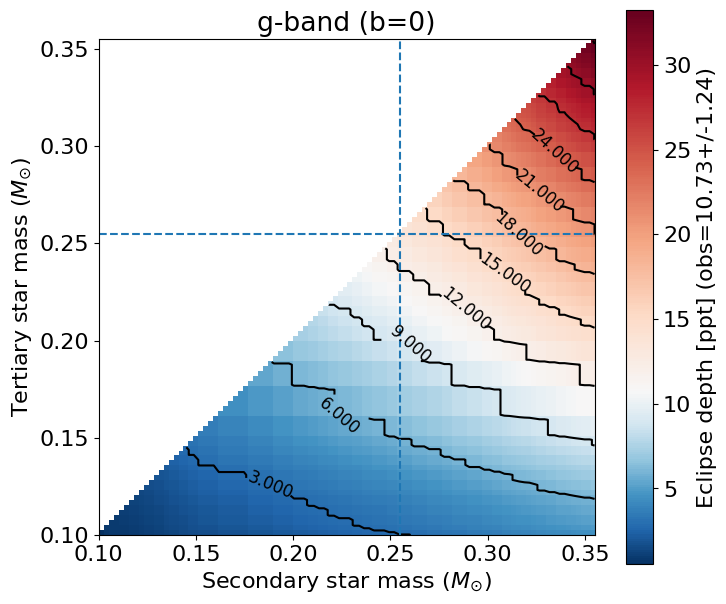

In [35]:
imp_par = 0
factor = 1e3
depth = obs_depths[bp1]
grid = depth_grids[imp_par][bp1]
label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'
ax = plot_grid(grid*1e3, 
                m2s, m3s, 
                cmap="RdBu_r", 
                use_norm_cbar=True, 
                use_log_cbar=False,
                reference=depth.nominal_value*factor,         
                cbar_label=label, 
                aspect_ratio=1,
               m1=Mstar[0]
               )
ax.set_title(f"{bp1.split('_')[1][0]}-band (b={imp_par})")
contours = ax.contour(m2s, m3s, grid*factor, 10, colors='black');
ax.clabel(contours, inline=True, fontsize=12)

## changing bands

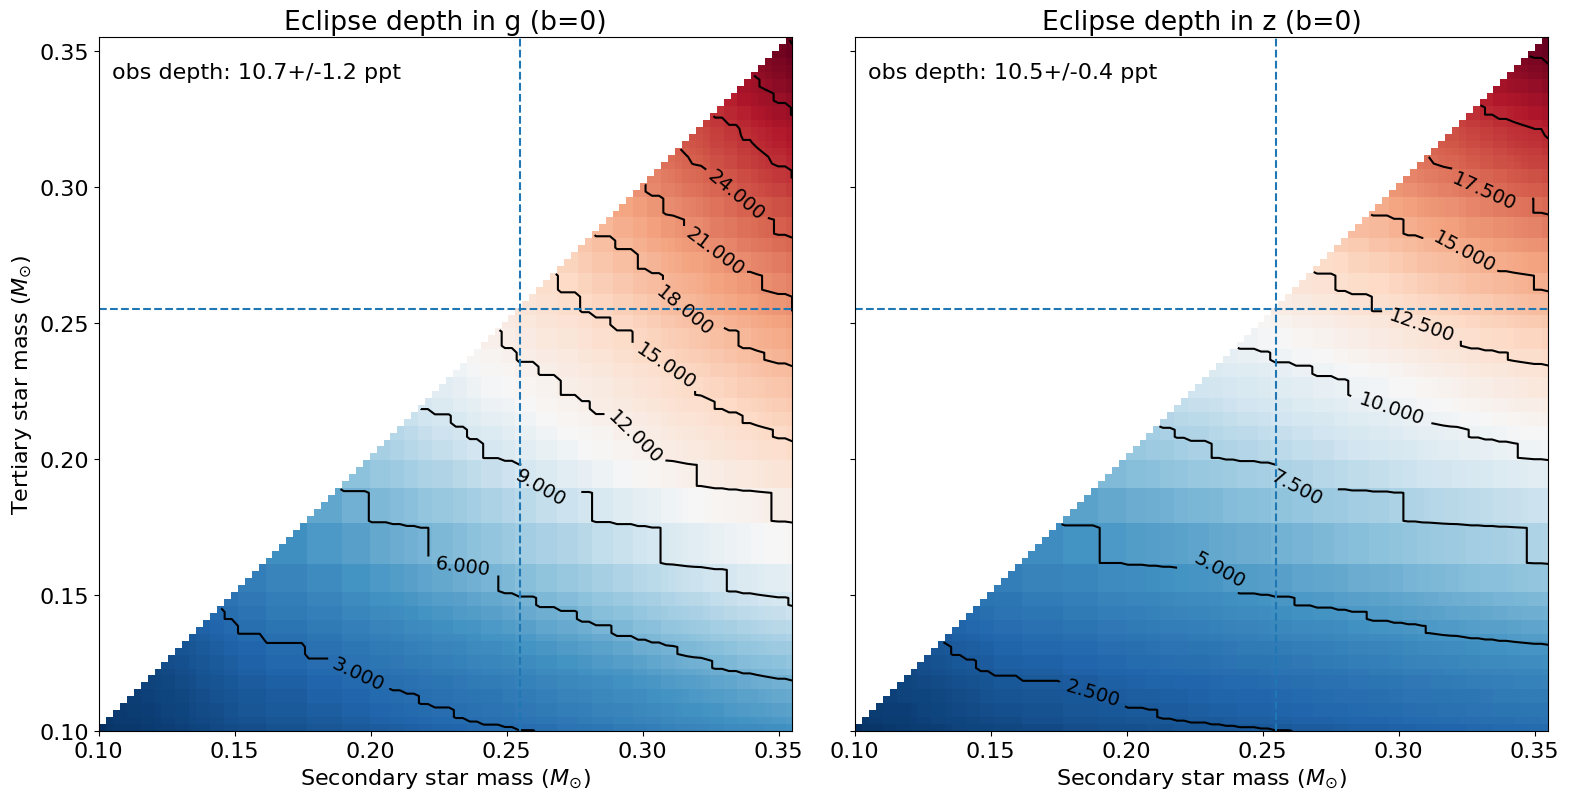

In [36]:
imp_par = 0

fig, axs = pl.subplots(1, 2, figsize=(16, 8), sharey=True, tight_layout=True)

for n,bp in enumerate(masked_depth_grids[imp_par]):
    ax = axs[n]
    grid = depth_grids[imp_par][bp]
    depth = obs_depths[bp]
    label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'
    _ = plot_grid(grid*1e3, 
                    m2s, m3s, 
                    cmap="RdBu_r", 
                  show_cbar=False,
                    use_norm_cbar=True, 
                    use_log_cbar=False,
                    reference=depth.nominal_value*1e3,         
                    cbar_label=label, 
                    aspect_ratio=1,
                  m1=Mstar[0],
                    ax=ax
                   )
#     ax.set_title(f"{bp} (b={imp_par})")
    ax.set_title(f"Eclipse depth in {bp.split('_')[1][0]} (b={imp_par})")
    
    x,y = 0.105, 0.34 #0.24
    ax.text(x,y,f"obs depth: {depth*factor} ppt")
    
    if n==1:
        ax.set_ylabel("")
    
    contours = ax.contour(m2s, m3s, grid*1e3, 10, colors='black');
    ax.clabel(contours, inline=True, fontsize=14)

In [16]:
fig.savefig('../../toi1696/paper/figures/heb_M2gz_b0.png', bbox_inches='tight')

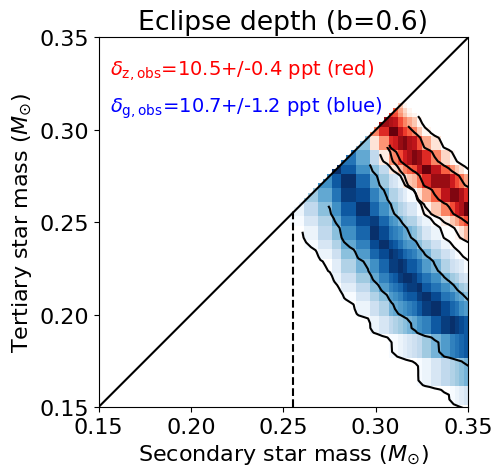

In [37]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl

#make cmap which is bright on center and light on outer
x=np.linspace(0,1,20)
cmap = mpl.cm.Blues(np.concatenate((x,x[::-1])))
cmap1 = mpl.colors.ListedColormap(cmap)
cmap = mpl.cm.Reds(np.concatenate((x,x[::-1])))
cmap2 = mpl.colors.ListedColormap(cmap)

fig, ax = pl.subplots()
b = 0.6
for bp,cmap in zip([bp1,bp2],[cmap1,cmap2]):
    depth = obs_depths[bp]*factor
    n,s = obs_depths[bp].n, obs_depths[bp].s
#     level1 = np.array([0, n])*factor
    level1 = np.array([0, n-s, n+s])*factor
    level2 = np.array([0, n-2*s, n+2*s])*factor
    grid = depth_grids[b][bp]*factor
        #replace nan
#         grid[np.isnan(grid)] = 0
    grid = gaussian_filter(grid, sigma=0.7)
    mgrid = masked_depth_grids[b][bp]
#     img = gaussian_filter(grid*1e3, sigma=0.5)
    _ = plot_grid(mgrid, 
                    m2s, m3s, 
                    cmap=cmap,
                    show_cbar=False,
                    use_norm_cbar=False,
                    use_log_cbar=False,
                    aspect_ratio=1,
#                   m1=Mstar[0],
                    ax=ax
                   )
    c1 = ax.contour(m2s, m3s, grid, levels=level1, colors='k');
#     ax.clabel(c1, inline=True, fontsize=16, fmt='%1.1f')
    
    c2 = ax.contour(m2s, m3s, grid, levels=level2, colors='k');
#     ax.clabel(c2, inline=True, fontsize=14)
    
ax.text(0.156, 0.31, r"$\delta_{\rm{g,obs}}$="+f"{obs_depths[bp1]*factor} ppt (blue)", fontsize=14, color='blue')
ax.text(0.156, 0.33,r"$\delta_{\rm{z,obs}}$="+f"{obs_depths[bp2]*factor} ppt (red)", fontsize=14, color='red')
ax.set_title(f"Eclipse depth (b={b})")
ax.plot(m2s, m3s, c='k', ls='-')
ax.axvline(Mstar[0], 0, 0.53, c='k', ls='--')
ax.set_ylim(0.15,0.35)
ax.set_xlim(0.15,0.35)
ax.locator_params(axis='y', nbins=4)
ax.locator_params(axis='x', nbins=4)

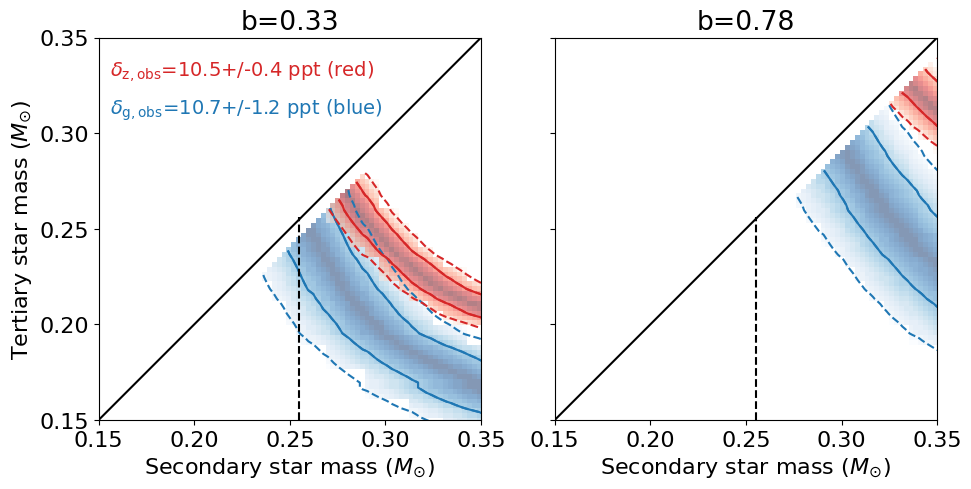

In [38]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import zoom

fig, axs = pl.subplots(1, 2, figsize=(10,5), tight_layout=True, sharey=True)
axs.flatten()
for i,b in enumerate([0.33,0.78]):
    ax=axs[i]
    for bp,cmap,color in zip([bp1,bp2],[cmap1,cmap2],['C0','C3']):
        depth = obs_depths[bp]*factor
        n,s = obs_depths[bp].n, obs_depths[bp].s
#         level1 = np.array([0, n])*factor
        #1 sigma
        level1 = np.array([0, n-s, n+s])*factor
        #1 and 2sigma
        level2 = np.array([0, n-2*s, n-s, n+s, n+2*s])*factor
        grid = depth_grids[b][bp]*factor
        grid = gaussian_filter(grid, sigma=3, truncate=0.5)
        mgrid = masked_depth_grids[b][bp]
        _ = plot_grid(np.ma.array(grid, mask=mgrid.mask), 
                        m2s, m3s, 
                        cmap=cmap, 
                        show_cbar=False,
                        use_norm_cbar=False, 
                        use_log_cbar=False,
                        aspect_ratio=1,
                        alpha=0.5,
    #                   m1=Mstar[0],
                        ax=ax
                       )
        c1 = ax.contour(m2s, m3s, grid, levels=level1, colors=color, linestyles='-');
#         ax.clabel(c1, inline=True, fontsize=16, fmt='%1.1f')

        c2 = ax.contour(m2s, m3s, grid, levels=level2, colors=color, linestyles='--');
    #     ax.clabel(c2, inline=True, fontsize=14)

    if i==0:
        ax.text(0.156, 0.31, r"$\delta_{\rm{g,obs}}$="+f"{obs_depths[bp1]*factor} ppt (blue)", fontsize=14, color='C0')
        ax.text(0.156, 0.33,r"$\delta_{\rm{z,obs}}$="+f"{obs_depths[bp2]*factor} ppt (red)", fontsize=14, color='C3')
    else:
        ax.set_ylabel("")
    ax.set_title(f"b={b}")
    ax.plot(m2s, m3s, c='k', ls='-')
    ax.axvline(Mstar[0], 0, 0.53, c='k', ls='--')
    ax.set_ylim(0.15,0.35)
    ax.set_xlim(0.15,0.35)
    ax.locator_params(axis='y', nbins=4)
    ax.locator_params(axis='x', nbins=4)

In [19]:
fig.savefig('../../toi1696/paper/figures/heb_depth_summary.png', bbox_inches='tight')

## changing impact parameter

In [13]:
depth_grids.keys()

dict_keys([0, 0.6, 0.89])

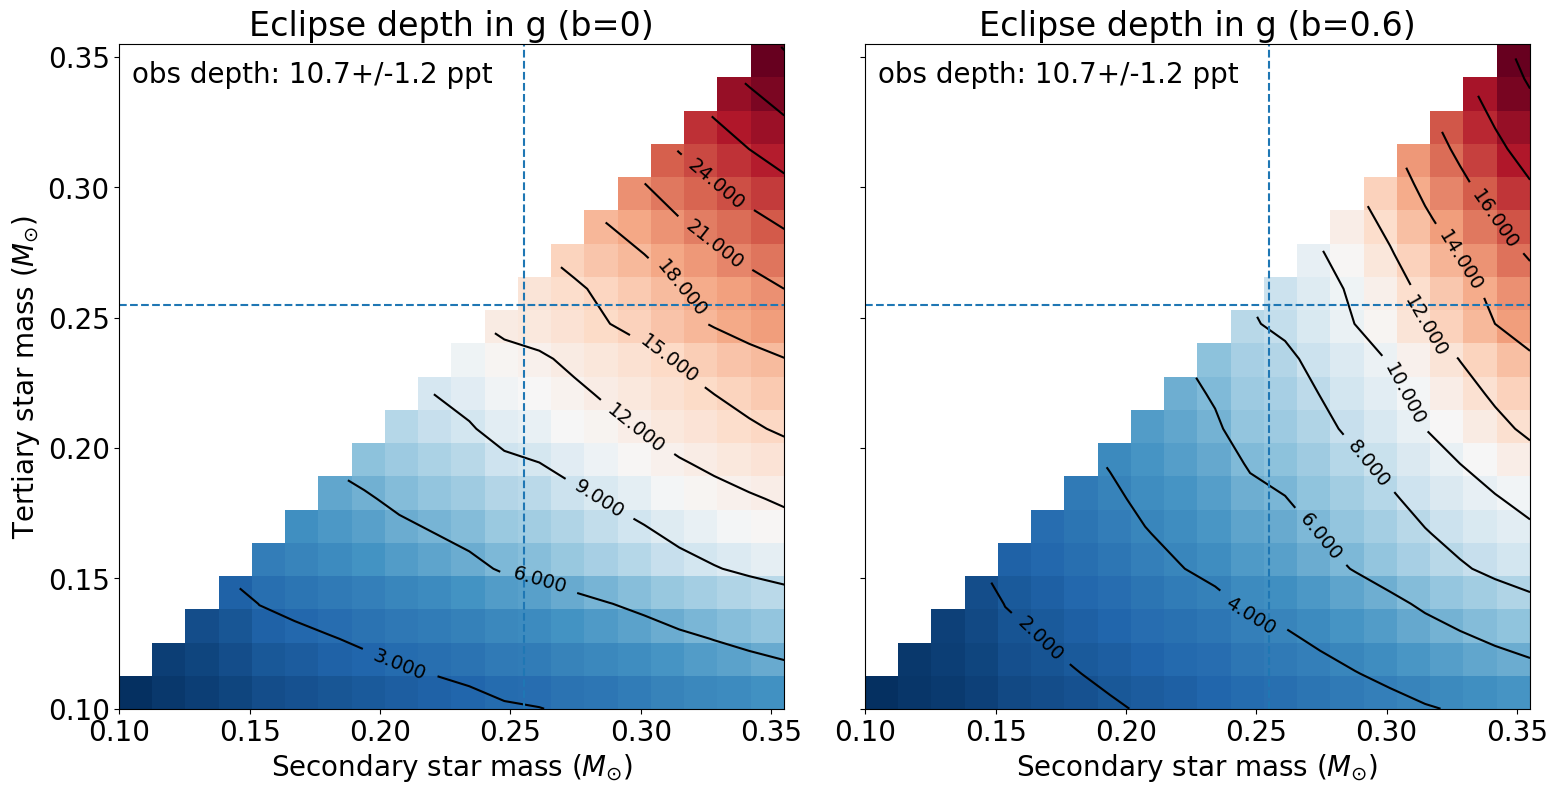

In [81]:
pl.rcParams['font.size'] = 20

depth = obs_depths[bp1]
label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'

fig, axs = pl.subplots(1, 2, figsize=(16, 8), sharey=True, tight_layout=True)

for n,imp_par in enumerate([0,0.6]):
    ax = axs[n]
    grid = depth_grids[imp_par][bp1]
    _ = plot_grid(grid*factor, 
                    m2s, m3s, 
                    cmap="RdBu_r", 
                    use_norm_cbar=True, 
                    use_log_cbar=False,
                  show_cbar=False,
                    reference=depth.nominal_value*factor,         
                    cbar_label=label, 
                    aspect_ratio=1,
                    cbar_shrink=0.8,
                  m1=Mstar[0],
                    ax=ax
                   )
    #ax.set_title(f"{bp1.split('_')[1][0]}-band (b={imp_par})")
    ax.set_title(f"Eclipse depth in {bp.split('_')[1][0]} (b={imp_par})")
    
    x,y = 0.105, 0.34 #0.24
    ax.text(x,y,f"obs depth: {depth*factor} ppt")
    
    if n==1:
        ax.set_ylabel("")
    contours = ax.contour(m2s, m3s, grid*factor, 10, colors='black');
    ax.clabel(contours, inline=True, fontsize=14)

In [68]:
fig.savefig('../../toi1696/paper/figures/heb_M2g.png', bbox_inches='tight')

## tshape

In [15]:
obs_tshapes

{0: {'TESS': 0.8261504747991235+/-0.010337959225488098,
  'MuSCAT2_gp2': 0.812250815512867+/-0.009852759054981154,
  'MuSCAT2_zs2': 0.8138944313440957+/-0.0032902130080611196},
 0.6: {'TESS': 0.7391729793276943+/-0.01501960156182315,
  'MuSCAT2_gp2': 0.7190122224563729+/-0.014268333510788316,
  'MuSCAT2_zs2': 0.7213928604436232+/-0.004766451706145914},
 0.89: {'TESS': 0.25535718177364797+/-0.058184522854807845,
  'MuSCAT2_gp2': 0.16385500265338807+/-0.07963010907248495,
  'MuSCAT2_zs2': 0.17669938728955176+/-0.024896967121671464}}

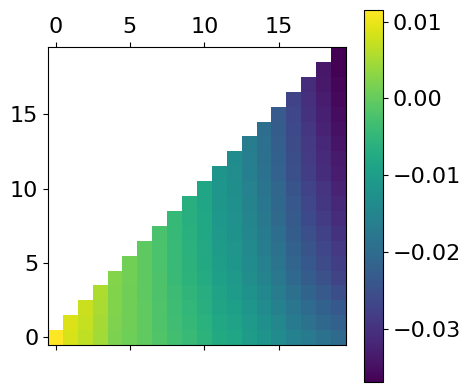

In [16]:
tshape_diff = tshape_grids[imp_par][bp1]-tshape_grids[imp_par][bp2]
pl.matshow(tshape_diff, origin='lower')
pl.colorbar()

<a list of 8 text.Text objects>

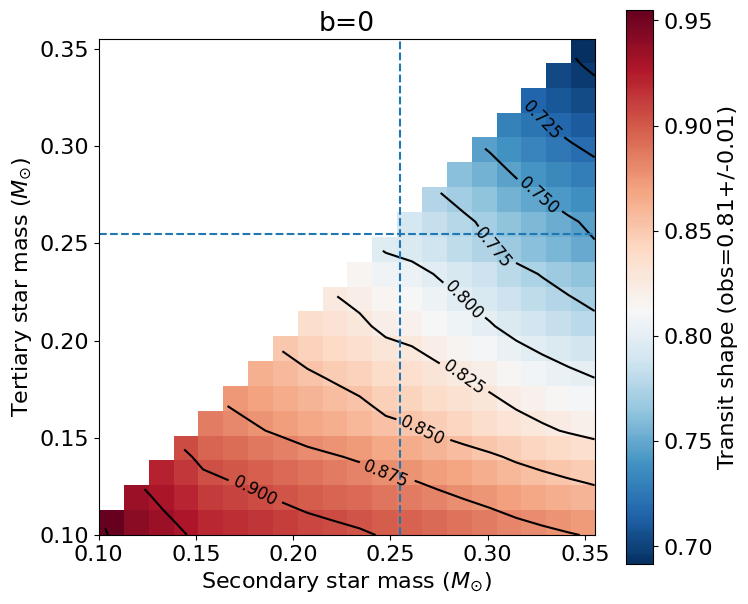

In [43]:
imp_par = 0
tshape = obs_tshapes[imp_par][bp1]
grid = tshape_grids[imp_par][bp1]
label = f'Transit shape (obs={tshape:.2f})'
ax = plot_grid(grid, 
                m2s, m3s, 
                cmap="RdBu_r", 
                use_norm_cbar=True, 
                use_log_cbar=False,
                reference=tshape.nominal_value,         
                cbar_label=label, 
                aspect_ratio=1,
               m1=Mstar[0],
               )
ax.set_title(f"b={imp_par}")

contours = ax.contour(m2s, m3s, grid, 10, colors='black');
ax.clabel(contours, inline=True, fontsize=12)

0.72(ref)<0.75(vmin)! Using cmap=Reds_r.
Cannot normalize cbar!


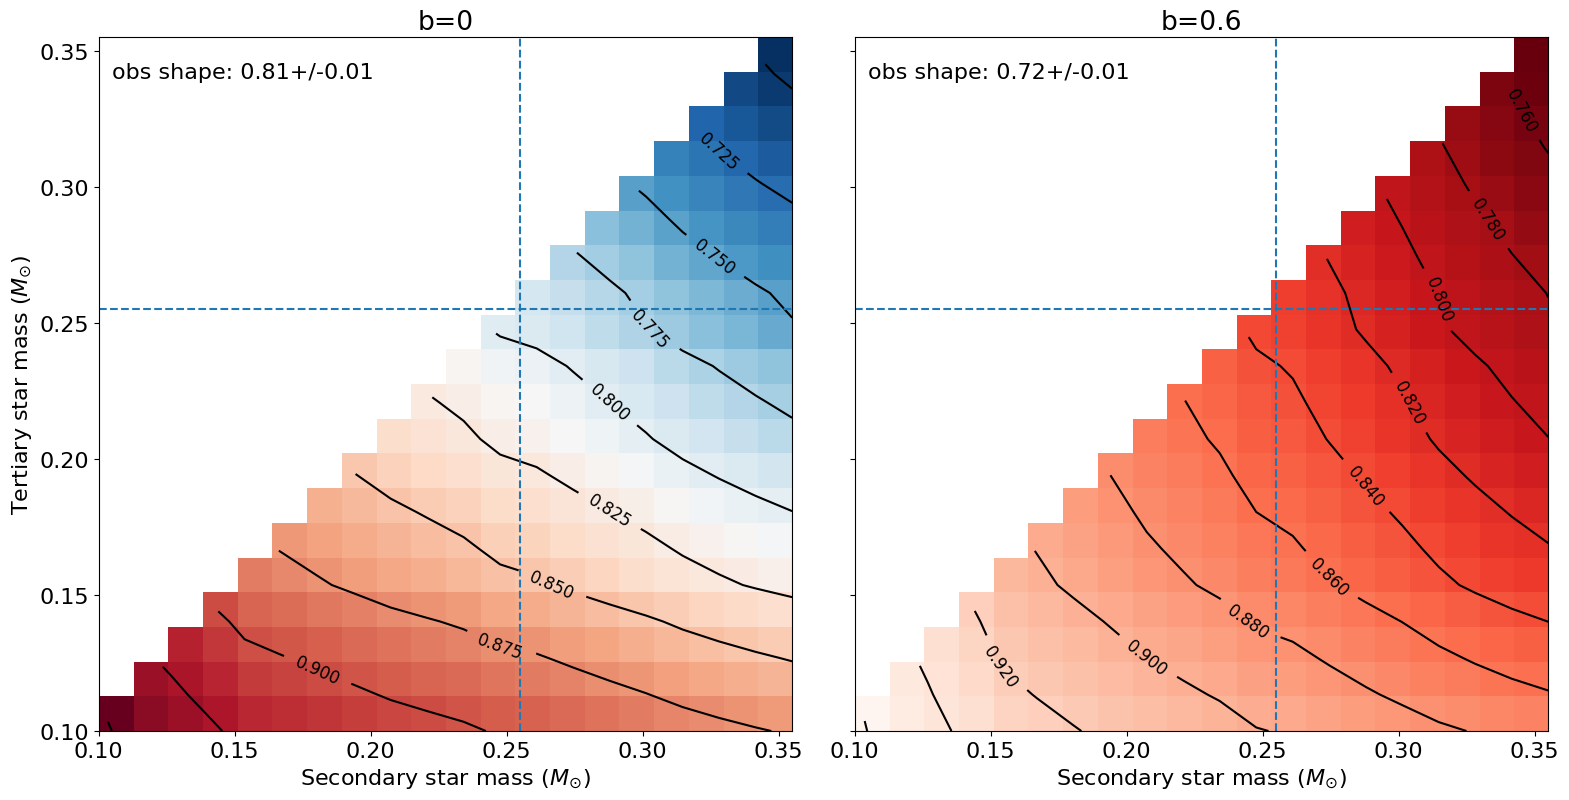

In [78]:
fig, axs = pl.subplots(1, 2, figsize=(16, 8), sharey=True, tight_layout=True)

for n,imp_par in enumerate([0,0.6]):
    ax = axs[n]
    tshape = obs_tshapes[imp_par][bp1]
    grid = tshape_grids[imp_par][bp1]
    label = f'Transit shape (obs={tshape:.2f})'
    _ = plot_grid(grid, 
                m2s, m3s, 
                cmap="RdBu_r", 
                  show_cbar=False,
                use_norm_cbar=True, 
                use_log_cbar=False,
                reference=tshape.nominal_value,         
                cbar_label=label, 
                aspect_ratio=1,
                  m1=Mstar[0],
                  ax=ax
                   )
    
    ax.set_title(f"b={imp_par}")
    x,y = 0.105, 0.34 #0.24
    ax.text(x,y,f"obs shape: {tshape:.2f}")
    
    contours = ax.contour(m2s, m3s, grid, 10, colors='black');
    ax.clabel(contours, inline=True, fontsize=12)
    
    if n==1:
        ax.set_ylabel("")

## summary

0.72(ref)<0.79(vmin)! Using cmap=Reds_r.
Cannot normalize cbar!


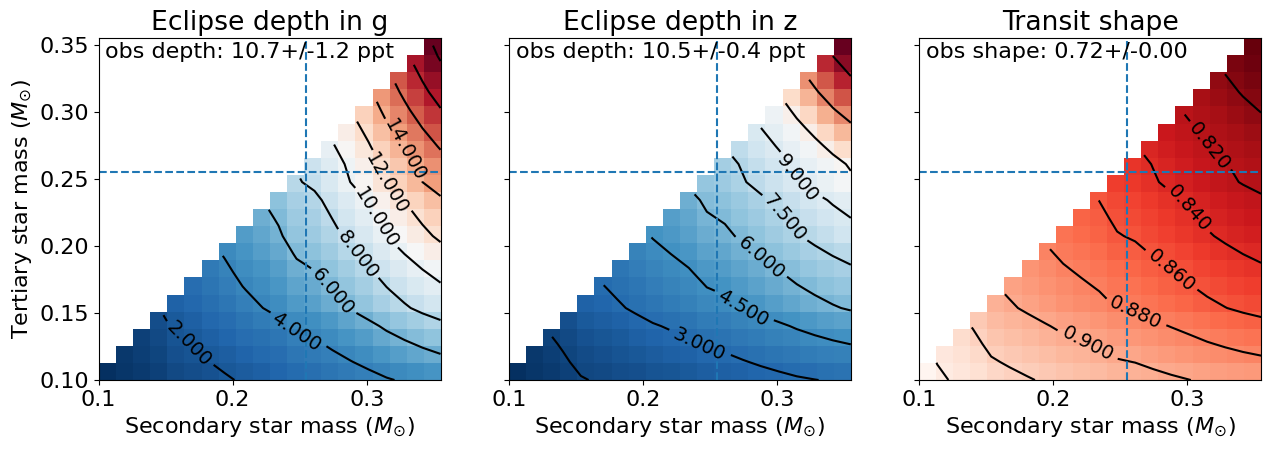

In [73]:
fig, axs = pl.subplots(1, 3, figsize=(15, 5), sharey=True)

imp_par = 0.6
factor = 1e3
for n,bp in enumerate([bp1,bp2,bp2]):
    ax = axs[n]
    
    depth = obs_depths[bp]
    tshape = obs_tshapes[imp_par][bp]
    if n<2:
        label = f'Eclipse depth [ppt] (obs={depth*factor:.2f})'
        grid = depth_grids[imp_par][bp]*factor
        reference = depth.nominal_value*factor
    else:
        label = f'Transit shape (obs={tshape:.2f})'
        grid = tshape_grids[imp_par][bp]
        reference = tshape.nominal_value
    _ = plot_grid(grid, 
                    m2s, m3s, 
                    cmap="RdBu_r", 
                    use_norm_cbar=True, 
                    use_log_cbar=False,
                    reference=reference,   
                    show_cbar=False,
                    cbar_label=label, 
                    cbar_shrink=0.8,
                    aspect_ratio=1,
                  m1=Mstar[0],
                    ax=ax
                   )
    if n!=0:
        ax.set_ylabel("")
    x,y = 0.105, 0.34 #0.24
    if n<2:
        ax.set_title(f"Eclipse depth in {bp.split('_')[1][0]}")
        ax.text(x,y,f"obs depth: {depth*factor} ppt")
    else:
        ax.set_title(f"Transit shape")
        ax.text(x,y,f"obs shape: {tshape:.2f}")
    contours = ax.contour(m2s, m3s, grid, 10, colors='black');
    ax.clabel(contours, inline=True, fontsize=14)

In [74]:
# fig.savefig(f'../../toi1696/paper/figures/heb_joint_b{imp_par}.png', bbox_inches='tight')
fig.savefig('../../toi1696/paper/figures/heb_joint.png', bbox_inches='tight')

## joint constraints

In [87]:
b = 0.6
idxs = []
for bp in masked_depth_grids[b].keys():
    idx = masked_depth_grids[b][bp].mask
    idxs.append(~idx)
#tshape
idxs.append(~masked_tshape_grids[b]['MuSCAT2_gp2'].mask)
idx = np.sum(idxs, axis=0)

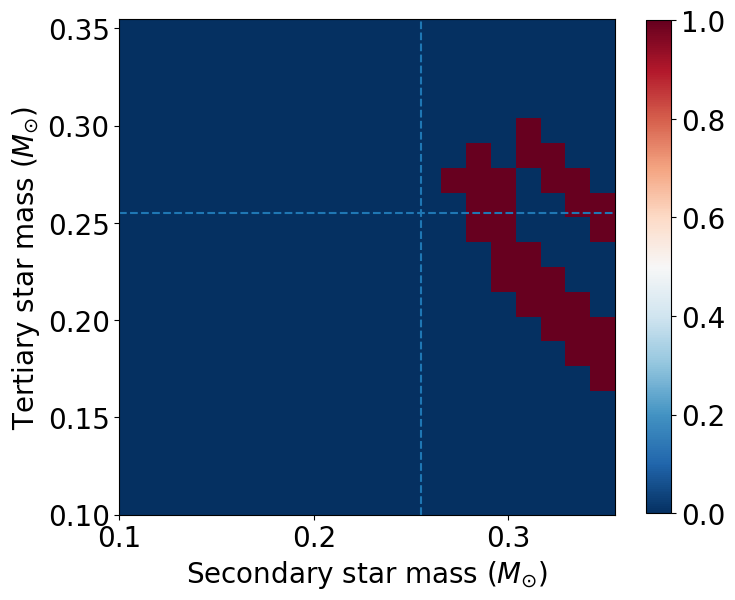

In [88]:
ax = plot_grid(idx, 
                m2s, m3s, 
                cmap="RdBu_r", 
                use_norm_cbar=False, 
                use_log_cbar=False,
                reference=None,         
                cbar_label="", 
                cbar_shrink=0.8,
                aspect_ratio=1,
               m1=Mstar[0]
                )

## all impact parameters

In [ ]:
fig, axs = pl.subplots(1, 2, figsize=(16, 8), sharey=True)

factor = 1e3
for n,bp in enumerate([bp1,bp2]):
    ax = axs[n]
    idxs = []
    for b in masked_depth_grids.keys():
        idx = masked_depth_grids[b][bp].mask
        idxs.append(~idx)
    idx = np.any(idxs, axis=0)
    
    grid = depth_grids[0][bp]*factor
    depth = obs_depths[bp]*factor
    label = f"Eclipse depth (obs={depth:.2f} ppt)"
    _ = plot_grid(np.ma.array(grid, mask=~idx), 
                    m2s, m3s, 
                    cmap="RdBu_r", 
                    use_norm_cbar=False, 
                    use_log_cbar=False,
                    reference=depth.nominal_value*factor,         
                    cbar_label=label, 
                    cbar_shrink=0.8,
                    aspect_ratio=1,
                    ax=ax
                   )
    ax.set_title(f"{bp.split('_')[1][0]}-band")
#     contours = ax.contour(m2s, m3s, grid*factor, 10, colors='black');
#     ax.clabel(contours, inline=True, fontsize=14)